# Uso de Técnicas de Machine Learning prar criar modelos capazer de prever o preço da Soja Brasileira em US$ / BU 


## 1. Introdução


A precificação de commodities agrícolas, como a soja, é um desafio complexo devido à sua natureza volátil e à influência de múltiplos fatores globais e locais. Para produtores, investidores e outros agentes do agronegócio, a capacidade de prever os preços da soja é fundamental para o planejamento estratégico, a gestão de riscos e a otimização de resultados.

Este projeto tem como objetivo desenvolver e avaliar modelos de Machine Learning para a previsão do preço da soja (em US$/BU), utilizando um conjunto de dados que abrange variáveis macroeconômicas, de produção e logística.

A análise se inicia com a exploração dos dados e a criação de um modelo de referência utilizando a Regressão Linear, uma técnica consolidada e altamente interpretável. A partir dos resultados deste primeiro modelo, investigaremos suas limitações e exploraremos abordagens mais avançadas para aprimorar a precisão e a robustez da previsão.

## 2. Referencial Teórico


- Fundamentação Teórica: Análise e Previsão de Preços de Commodities Agrícolas : https://docs.google.com/document/d/1lopI4fpfCaDl-D-d9RXpcecLOIO06FJnWxEe0a-sm0g/edit?usp=sharing
- Infográfico: A Dinâmica do Mercado de Soja : https://g.co/gemini/share/50dc9b09f26b

## 3. Materiais e Métodos


### 3.1. Seleção e Descrição de Dados


Para a construção do nosso modelo preditivo, foi consolidado um conjunto de dados que abrange as principais variáveis que, com base na teoria econômica, influenciam a formação de preços da soja. As variáveis foram coletadas de fontes públicas e confiáveis, abrangendo o período de [seu período de dados].

Abaixo, descrevemos cada uma das variáveis utilizadas:

* **Variável Alvo (Y):**
    * **`SOJA - US$ / BU`**: Preço internacional da soja, cotado em dólares americanos por bushel. É a variável que nosso modelo buscará prever.
        * **Fonte:** CBOT (Chicago Board of Trade).
        * **Relevância:** Funciona como o principal benchmark para o mercado global.

* **Variáveis Preditoras (X):**
    * **`MILHO - US$ / BU`**: Preço internacional do milho.
        * **Fonte:** CBOT.
        * **Relevância:** O milho compete com a soja por área plantada e tem mercados consumidores correlacionados (ex: ração animal), tornando seu preço um importante indicador preditivo.
    * **`Área colhida (Hectares)` e `Produção (Toneladas)`**: Indicadores de oferta física da soja no Brasil.
        * **Fonte:** IBGE / CONAB.
        * **Relevância:** Representam o volume e a capacidade produtiva do país, fatores fundamentais de oferta.
    * **`Total Importado (ton)`**: Volume total de soja importado pelo Brasil.
        * **Fonte:** Registros de Comércio Exterior (ex: Comex Stat).
        * **Relevância:** Embora o Brasil seja um grande exportador, importações pontuais podem sinalizar desequilíbrios no balanço de oferta e demanda interno.
    * **`Valor do Frete (US$)`**: Custo logístico para transporte da commodity.
        * **Fonte:** Índices de frete, como o Baltic Dry Index, podem servir como proxy.
        * **Relevância:** Impacta diretamente a margem de lucro e o preço final da soja no mercado internacional.
    * **`Taxa de Câmbio`**: Taxa de câmbio nominal Real (BRL) vs. Dólar Americano (USD).
        * **Fonte:** Banco Central do Brasil (BACEN).
        * **Relevância:** Fator crucial para a conversão dos preços internacionais para o mercado doméstico e para a competitividade da soja brasileira no exterior.


In [1]:
#Import necessary libraries:
#%pip install html5lib statsmodels
import pandas as pd
import numpy as np

#### a) Preço internacional da SOJA e MILHO em Dólar por (CBOT - Chicago Board of Trade)


##### Primeiro Caminho:


In [2]:
html ="https://ftp.ibge.gov.br/Producao_Agricola/Levantamento_Sistematico_da_Producao_Agricola_%5Bmensal%5D/Tabelas_xls/2018/lspa_201801_01.xls"

df= pd.read_excel(html , header=4, skipfooter=2, engine='xlrd')
df = df.rename(columns={'MÊS ATUAL': 'ÁREA (ha)',
                        'MÊS ATUAL.1': 'PRODUÇÃO (t)',     
                        'MÊS ATUAL.2': 'RENDIMENTO MÉDIO (kg/ha)',
})
df= df.drop(columns=['MÊS ANTERIOR', 
                    'VARIAÇÃO %',
                    'MÊS ANTERIOR.1',
                    'VAR. %', 
                    'MÊS ANTERIOR.2', 
                    'VAR. %.1'
])
df = df[df['Unnamed: 0'].str.strip().str.lower() == 'soja']
df = df.drop(columns=['Unnamed: 0'])
df



,ÁREA (ha),PRODUÇÃO (t),RENDIMENTO MÉDIO (kg/ha)
30,34 561 420,112 433 054,3 253


In [3]:
import pandas as pd
from datetime import datetime
from tqdm import tqdm
import requests

def baixar_soja_ibge(start='2018-03', end='2025-04', max_sufixos=5):
    url_pattern = (
        "https://ftp.ibge.gov.br/Producao_Agricola/"
        "Levantamento_Sistematico_da_Producao_Agricola_%5Bmensal%5D/"
        "Tabelas_xls/{year}/lspa_{year}{month}_{suffix}.xls"
    )
    dates = pd.date_range(start=start, end=end, freq='MS')
    results = []
    logs = []

    for dt in tqdm(dates, desc="Meses"):
        year, month = dt.strftime('%Y'), dt.strftime('%m')
        df = None
        found_suffix = None
        
        for s in range(1, max_sufixos + 1):
            suffix = f"{s:02d}"
            url = url_pattern.format(year=year, month=month, suffix=suffix)
            r = requests.head(url)
            if r.status_code == 200:
                found_suffix = suffix
                df = pd.read_excel(url, header=3, skipfooter=2, engine='xlrd')
                break
        
        logs.append({'data': dt, 'suffix': found_suffix, 'status': 'ok' if df is not None else 'not found'})
        if df is None:
            continue
        
        # Identificar dinamicamente as colunas relevantes
        columns = df.columns.str.strip().str.lower()
        area_col = next((col for col in columns if 'área' in col), None)
        prod_col = next((col for col in columns if 'produção' in col), None)
        rend_col = next((col for col in columns if 'rendimento' in col), None)
        culture_col = next((col for col in columns if 'cultura' in col), None)
        
        if not all([area_col, prod_col, rend_col, culture_col]):
            logs[-1]['status'] = 'missing columns'
            continue
        
        # Filtrar a linha de soja
        df_soja = df[df[culture_col].str.strip().str.lower() == 'soja']
        if df_soja.empty:
            logs[-1]['status'] = 'no soja line'
            continue
        
        # Selecionar e renomear as colunas
        df_soja = df_soja[[area_col, prod_col, rend_col]]
        df_soja.columns = ['Área (ha)', 'Produção (t)', 'Rendimento Médio (kg/ha)']
        df_soja['Data'] = dt
        results.append(df_soja)

    df_logs = pd.DataFrame(logs)
    return (pd.concat(results, ignore_index=True) if results else pd.DataFrame(), df_logs)

df_soja, df_logs = baixar_soja_ibge()
print(df_soja.head(), df_soja.shape)


Meses: 100%|██████████| 86/86 [00:28<00:00,  3.06it/s]

Empty DataFrame
Columns: []
Index: [] (0, 0)


##### Segundo caminho:


In [4]:
# Preço da Soja em Dólar (USS) - Histórico
df_soy_USS_hist = pd.read_csv(r"D:\Documentos e Arquivos\Apresentação_TMQUANT\Datasets\Dataset\soy_USS_hist.csv", sep = ',' , encoding = 'utf-8')
# Converter a coluna 'Data' para datetime
df_soy_USS_hist['Data'] = pd.to_datetime(df_soy_USS_hist['Data'], format='%d.%m.%Y')

# Função para converter valores numéricos com vírgula e sufixos (K, M)
def parse_number(x):
    if isinstance(x, str):
        x = x.replace('.', '').replace(',', '.')
        if 'K' in x:
            return float(x.replace('K', '')) * 1_000
        elif 'M' in x:
            return float(x.replace('M', '')) * 1_000_000
        else:
            return float(x)
    return np.nan

# Converter colunas numéricas
for col in ['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.']:
    df_soy_USS_hist[col] = df_soy_USS_hist[col].apply(parse_number)

# Converter coluna de variação percentual
df_soy_USS_hist['Var%'] = df_soy_USS_hist['Var%'].str.replace('%', '').str.replace(',', '.').astype(float)
df_soy_USS_hist = df_soy_USS_hist[['Data', 'Último']]
df_soy_USS_hist = df_soy_USS_hist.rename(columns={'Último': 'SOJA - US$ / BU'})

# Preço do Milho em Dólar (USS) - Histórico
df_corn_USS_hist = pd.read_csv(r"D:\Documentos e Arquivos\Apresentação_TMQUANT\Datasets\Dataset\corn_USS_hist.csv", sep = ',' , encoding = 'utf-8')
# Converter a coluna 'Data' para datetime
df_corn_USS_hist['Data'] = pd.to_datetime(df_corn_USS_hist['Data'], format='%d.%m.%Y')

# Função para converter valores numéricos com vírgula e sufixos (K, M)
def parse_number(x):
    if isinstance(x, str):
        x = x.replace('.', '').replace(',', '.')
        if 'K' in x:
            return float(x.replace('K', '')) * 1_000
        elif 'M' in x:
            return float(x.replace('M', '')) * 1_000_000
        else:
            return float(x)
    return np.nan

# Converter colunas numéricas
for col in ['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.']:
    df_corn_USS_hist[col] = df_corn_USS_hist[col].apply(parse_number)

# Converter coluna de variação percentual
df_corn_USS_hist['Var%'] = df_corn_USS_hist['Var%'].str.replace('%', '').str.replace(',', '.').astype(float)
df_corn_USS_hist = df_corn_USS_hist[['Data', 'Último']]
df_corn_USS_hist = df_corn_USS_hist.rename(columns={'Último': 'MILHO - US$ / BU'})


# Unir os dataframes de soja e milho pela coluna 'Data'
df_soy_corn_USS_hist = pd.merge(df_soy_USS_hist, df_corn_USS_hist, on='Data', how='inner')
df_soy_corn_USS_hist.head()

,Data,SOJA - US$ / BU,MILHO - US$ / BU
0,2025-06-01,1058.00,442.00
1,2025-05-01,1041.75,444.00
2,2025-04-01,1034.75,467.25
3,2025-03-01,1014.75,457.25
4,2025-02-01,1011.50,453.50


#### b) Taxa nominal do Dólar


In [5]:
# Taxa de Câmbio Nominal (USS) - Histórico
df_rate_nominal_USS = pd.read_csv(r"D:\Documentos e Arquivos\Apresentação_TMQUANT\Datasets\Dataset\rate_nominal_USS.csv" , sep=',', encoding='utf-8')
# Renomear as colunas para facilitar o uso
df_rate_nominal_USS = df_rate_nominal_USS.rename(columns={'DateTime': 'Data', 'Taxa de câmbio nominal': 'Taxa'})

# Converter a coluna 'Data' para datetime
df_rate_nominal_USS['Data'] = pd.to_datetime(df_rate_nominal_USS['Data'], format='%d/%m/%Y')

# Converter a coluna 'Taxa' para float, trocando vírgula por ponto
df_rate_nominal_USS['Taxa'] = df_rate_nominal_USS['Taxa'].str.replace('.', '', regex=False).str.replace(',', '.', regex=False).astype(float)
df_rate_nominal_USS['Taxa'] = df_rate_nominal_USS['Taxa'] / 10
# Transformar os dados diários em média mensal
df_rate_nominal_USS_mensal = df_rate_nominal_USS.resample('M', on='Data').mean().reset_index()
df_rate_nominal_USS = df_rate_nominal_USS_mensal 
# Garantir que todas as datas estejam no primeiro dia do mês
df_rate_nominal_USS['Data'] = df_rate_nominal_USS['Data'].apply(lambda d: d.replace(day=1))
df_rate_nominal_USS.tail()

C:\Users\Rubens Molina\AppData\Local\Temp\ipykernel_30132\2487305619.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_rate_nominal_USS_mensal = df_rate_nominal_USS.resample('M', on='Data').mean().reset_index()


,Data,Taxa
301,2025-02-01,5.765045
302,2025-03-01,5.746216
303,2025-04-01,5.783085
304,2025-05-01,5.666781
305,2025-06-01,5.636980


#### c) Área plantada (ha), Colhida (ha), Produção (ton) e Rendimento Médio (kg/ha)


In [6]:
# Informações Históricas da Soja - Produção, Área Plantada e Rendimento Médio
df_soy_info_hist = pd.read_excel(r"D:\Documentos e Arquivos\Apresentação_TMQUANT\Datasets\Dataset\soy_seed_hist.xlsx", sheet_name='Tabela', engine='openpyxl' , skiprows=0)
# Converter as colunas 'Produção (Toneladas)' e 'Rendimento médio (Quilogramas por Hectare)' para numérico

df_soy_info_hist = df_soy_info_hist.rename(columns={df_soy_info_hist.columns[0]: 'Data'})
# Converter a coluna 'Data' para datetime, tentando inferir o formato
import calendar

# Converter a coluna 'Data' de "setembro 2006" para "2006-09-01" (YYYY-MM-DD)
def mes_ano_para_data(x):
    try:
        partes = str(x).split()
        if len(partes) == 2:
            mes_nome, ano = partes
            # Corrige para minúsculo e remove acentos
            mes_nome = mes_nome.lower()
            # Dicionário de meses em português
            meses = {
                'janeiro': 1, 'fevereiro': 2, 'março': 3, 'marco': 3, 'abril': 4, 'maio': 5, 'junho': 6,
                'julho': 7, 'agosto': 8, 'setembro': 9, 'outubro': 10, 'novembro': 11, 'dezembro': 12
            }
            mes_num = meses.get(mes_nome, 1)
            return f"{ano}-{mes_num:02d}-01"
        return None
    except Exception:
        return None

df_soy_info_hist['Data'] = df_soy_info_hist['Data'].apply(mes_ano_para_data)
df_soy_info_hist['Data'] = pd.to_datetime(df_soy_info_hist['Data'], format='%Y-%m-%d', errors='coerce')
df_soy_info_hist = df_soy_info_hist.dropna()
print("Período de dados disponível no dataset de soja:")
print(f"Início: {df_soy_info_hist['Data'].min().date()}")
print(f"Fim:    {df_soy_info_hist['Data'].max().date()}")
df_soy_info_hist.head()


Período de dados disponível no dataset de soja:
Início: 2006-09-01
Fim:    2025-04-01


,Data,Área plantada (Hectares),Área colhida (Hectares),Produção (Toneladas),Rendimento médio (Quilogramas por Hectare)
224,2006-09-01,22046825,22010658,52381672.0,2380.0
225,2006-10-01,22046825,22010658,52356720.0,2379.0
226,2006-11-01,21991638,21955471,52223579.0,2379.0
227,2006-12-01,21994243,21958076,52234589.0,2379.0
228,2007-01-01,20686139,20686139,56395247.0,2726.0


#### d) Importação de Soja no Brasil:


In [10]:
# Importação de Soja - Histórico:
df_soy_import_hist = pd.read_excel(r"D:\Documentos e Arquivos\Apresentação_TMQUANT\Datasets\Dataset\soy_info_hist_data.xlsx", sheet_name='Importação', engine='openpyxl' , skiprows=0)
# Ajuste dos nomes das colunas para facilitar o uso
df_soy_import_hist =df_soy_import_hist.rename(columns={
    'Row Labels': 'Data',
    'Sum of Quilograma Líquido': 'Total Importado (kg)',
})
# Converter a coluna 'Data' para datetime (formato MM/YYYY ou similar)
df_soy_import_hist['Data'] = pd.to_datetime(df_soy_import_hist['Data'], format='%m/%Y', errors='coerce')
# Converter o peso de kg para toneladas (1 tonelada = 1000 kg)
df_soy_import_hist['Total Importado (ton)'] = df_soy_import_hist['Total Importado (kg)'] / 1000
# Remover a coluna em kg
df_soy_import_hist = df_soy_import_hist.drop(columns=['Total Importado (kg)'])
df_soy_import_hist = df_soy_import_hist.dropna(subset=['Data'])
df_soy_import_hist.head()

,Data,Total Importado (ton)
0,2013-01-01,24040.721
1,2014-01-01,17588.000
2,2015-01-01,18088.000
3,2016-01-01,23240.000
4,2017-01-01,3088.000


#### e) Valor do Frete total ( Máritmo e Fluvial):


In [11]:
# Valor do Frete da Soja no Brasil :
# Frete de Soja no Brasil :
df_freight = pd.read_excel(r"D:\Documentos e Arquivos\Apresentação_TMQUANT\Datasets\Dataset\soy_info_hist_data.xlsx" , sheet_name='US$ - Frete total ', engine='openpyxl' , skiprows=0)

# Ajuste dos nomes das colunas para facilitar o uso
df_freight = df_freight.rename(columns={
    'Row Labels': 'Data',
    'Sum of US$ Total': 'Valor do Frete (US$)'
})

# Converter a coluna 'Data' para datetime (formato MM/YYYY ou similar)
df_freight['Data'] = pd.to_datetime(df_freight['Data'], format='%m/%Y', errors='coerce')

# Remover linhas totais ou agregadas, mantendo apenas datas válidas
df_freight= df_freight.dropna(subset=['Data'])

# Converter a coluna de importação para numérico (caso não esteja)
df_freight['Valor do Frete (US$)'] = pd.to_numeric(df_freight['Valor do Frete (US$)'], errors='coerce')

df_freight.head()

,Data,Valor do Frete (US$)
0,2013-01-01,341671
1,2014-01-01,234648
2,2015-01-01,204874
3,2016-01-01,166780
4,2017-01-01,18243


#### f) IPCA


#### 3.2 União do Data frame:


In [35]:
# Verificação do tamanho dos dados:
print("a) Shape de df_soy_corn_USS_hist:", df_soy_corn_USS_hist.shape)
print("b) Shape de df_rate_nominal_USS:", df_rate_nominal_USS.shape)
print("c) Shape de df_soy_info_hist:", df_soy_info_hist.shape)
print("d) Shape de df_soy_import_hist:", df_freight.shape)
print("e) Shape de df_freight:", df_soy_import_hist.shape)

# Encontrar o maior início e o menor fim
dfs = [df_soy_corn_USS_hist, df_rate_nominal_USS, df_soy_info_hist, df_soy_import_hist, df_freight]
datas_inicio = [df['Data'].min() for df in dfs]
datas_fim = [df['Data'].max() for df in dfs]

periodo_comum_inicio = max(datas_inicio)
periodo_comum_fim = min(datas_fim)

print(f"Período em comum entre todos os dataframes:")
print(f"  Início: {periodo_comum_inicio.date()}")
print(f"  Fim:    {periodo_comum_fim.date()}")



a) Shape de df_soy_corn_USS_hist: (306, 3)
b) Shape de df_rate_nominal_USS: (306, 2)
c) Shape de df_soy_info_hist: (224, 5)
d) Shape de df_soy_import_hist: (154, 2)
e) Shape de df_freight: (154, 2)
Período em comum entre todos os dataframes:
  Início: 2012-02-01
  Fim:    2025-04-01


Merge com os dados em um df_unificado:


In [13]:
# Unir os principais DataFrames pela coluna 'Data', a partir de 2014

# Selecionar apenas as colunas relevantes de cada DataFrame
df_soy_info_hist_sel = df_soy_info_hist[['Data', #'Área plantada (Hectares)',
                                        #'Área colhida (Hectares)',
                                        'Produção (Toneladas)', 
                                        #'Rendimento médio (Quilogramas por Hectare)'
                                        ]]
df_soy_corn_USS_hist_sel = df_soy_corn_USS_hist[['Data', 'SOJA - US$ / BU', 'MILHO - US$ / BU']]
df_rate_nominal_USS_sel = df_rate_nominal_USS[['Data', 'Taxa']]
df_soy_import_hist_sel = df_soy_import_hist[['Data', 'Total Importado (ton)']]
df_freight_sel = df_freight[['Data', 'Valor do Frete (US$)']]

# Realizar as junções pela coluna 'Data'
df_unificado = df_soy_info_hist_sel.merge(df_soy_corn_USS_hist_sel, on='Data', how='outer') \
    .merge(df_rate_nominal_USS_sel, on='Data', how='outer') \
    .merge(df_soy_import_hist_sel, on='Data', how='outer') \
    .merge(df_freight_sel, on='Data', how='outer')

# Filtrar apenas dados a partir de 2014
df_unificado = df_unificado[df_unificado['Data'] >= '2014-01-01'].sort_values('Data').reset_index(drop=True)

# Reorganizar as colunas na ordem desejada
colunas_ordenadas = [
    'SOJA - US$ / BU',
    'MILHO - US$ / BU',
    'Área plantada (Hectares)',
    'Área colhida (Hectares)',
    'Produção (Toneladas)',
    'Total Importado (ton)',
    'Valor do Frete (US$)',
    'Taxa',
    'Rendimento médio (Quilogramas por Hectare)'
]
# Renomear a coluna 'Taxa' para 'Taxa de Câmbio'
df_unificado = df_unificado.rename(columns={'Taxa': 'Taxa de Câmbio'})
# Atualizar a lista de colunas ordenadas e existentes
colunas_ordenadas = [
    'SOJA - US$ / BU',
    'MILHO - US$ / BU',
    'Área plantada (Hectares)',
    'Área colhida (Hectares)',
    'Produção (Toneladas)',
    'Total Importado (ton)',
    'Valor do Frete (US$)',
    'Taxa de Câmbio',
    'Rendimento médio (Quilogramas por Hectare)'
]
colunas_existentes = [col for col in colunas_ordenadas if col in df_unificado.columns]
# Manter apenas as colunas que existem no DataFrame
colunas_existentes = [col for col in colunas_ordenadas if col in df_unificado.columns]
df_unificado = df_unificado[['Data'] + colunas_existentes]

# Exibir as primeiras linhas do DataFrame unificado
df_unificado.head() # Verificar se há valores ausentes

,Data,SOJA - US$ / BU,MILHO - US$ / BU,Produção (Toneladas),Total Importado (ton),Valor do Frete (US$),Taxa de Câmbio
0,2014-01-01,1283.88,434.00,91283222.0,17588.00,234648.0,2.381605
1,2014-02-01,1414.13,457.50,88442511.0,65328.45,628533.0,2.383090
2,2014-03-01,1462.38,502.00,86769230.0,81439.00,1169945.0,2.325495
3,2014-04-01,1511.38,514.00,86887561.0,70792.00,1007978.0,2.231725
4,2014-05-01,1491.13,465.75,86451711.0,86792.00,1088036.0,2.220281


In [41]:
# Contar o número de valores nulos em cada coluna do DataFrame df_unificado
df_unificado = df_unificado.fillna(0)  # Preencher valores nulos com 0
nulos_por_coluna = df_unificado.isnull().sum()
print(nulos_por_coluna)

Data                     0
SOJA - US$ / BU          0
MILHO - US$ / BU         0
Produção (Toneladas)     0
Total Importado (ton)    0
Valor do Frete (US$)     0
Taxa de Câmbio           0
dtype: int64


In [42]:
### 3.2. Tratamento da Base de Dados
# Preencher valores nulos de df_unificado
# Estratégia: interpolação para variáveis contínuas e preenchimento com 0 para importação/frete

df_unificado_interp = df_unificado.copy()

# Interpolação linear para colunas numéricas (exceto Data)
for col in df_unificado_interp.columns:
    if col != 'Data':
        df_unificado_interp[col] = df_unificado_interp[col].interpolate(method='linear', limit_direction='both')

# Para colunas de importação e frete, preencher nulos restantes com 0
df_unificado_interp['Total Importado (ton)'] = df_unificado_interp['Total Importado (ton)'].fillna(0)
df_unificado_interp['Valor do Frete (US$)'] = df_unificado_interp['Valor do Frete (US$)'].fillna(0)

# Verificar se ainda há valores nulos
df_unificado_interp.isnull().sum()

Data                     0
SOJA - US$ / BU          0
MILHO - US$ / BU         0
Produção (Toneladas)     0
Total Importado (ton)    0
Valor do Frete (US$)     0
Taxa de Câmbio           0
dtype: int64

Normalização dos dados de df_unificado:


In [43]:
# df_unificado com os dados normalizados:

from sklearn.preprocessing import MinMaxScaler

# Selecionar apenas as colunas numéricas (exceto 'Data')
colunas_numericas = df_unificado.select_dtypes(include=['float64', 'int64']).columns

# Instanciar o scaler
scaler = MinMaxScaler()

# Aplicar o scaler e criar um novo DataFrame normalizado
df_unificado_norm = df_unificado.copy()
df_unificado_norm[colunas_numericas] = scaler.fit_transform(df_unificado[colunas_numericas])

# Exibir as primeiras linhas do DataFrame normalizado
df_unificado_norm.head()
df_unificado = df_unificado_norm
df_unificado.head()

,Data,SOJA - US$ / BU,MILHO - US$ / BU,Produção (Toneladas),Total Importado (ton),Valor do Frete (US$),Taxa de Câmbio
0,2014-01-01,0.52,0.26,0.06,0.11,0.13,0.04
1,2014-02-01,0.68,0.30,0.03,0.39,0.36,0.04
2,2014-03-01,0.73,0.39,0.01,0.49,0.67,0.03
3,2014-04-01,0.79,0.41,0.01,0.43,0.57,0.00
4,2014-05-01,0.77,0.32,0.00,0.52,0.62,0.00


Análise de correlação entre as variáveis do DataFrame unificado


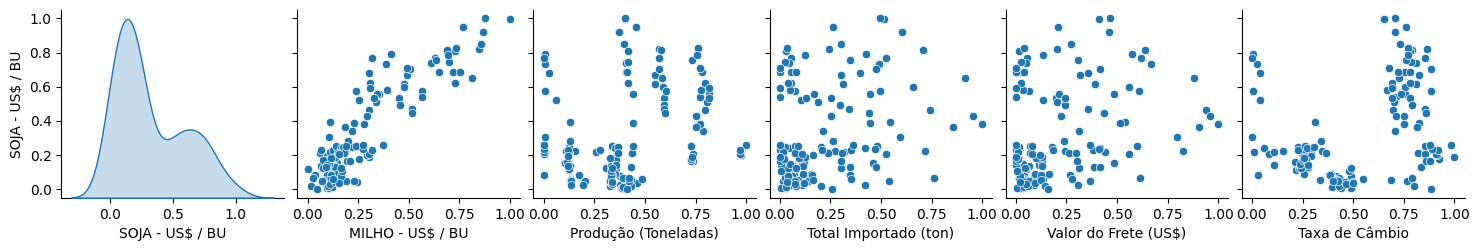

In [44]:
# Análise de correlação entre as variáveis do DataFrame unificado
import seaborn as sns
sns.pairplot(df_unificado, diag_kind='kde', y_vars=['SOJA - US$ / BU'])


Gráfico de correlação (Heat Map)


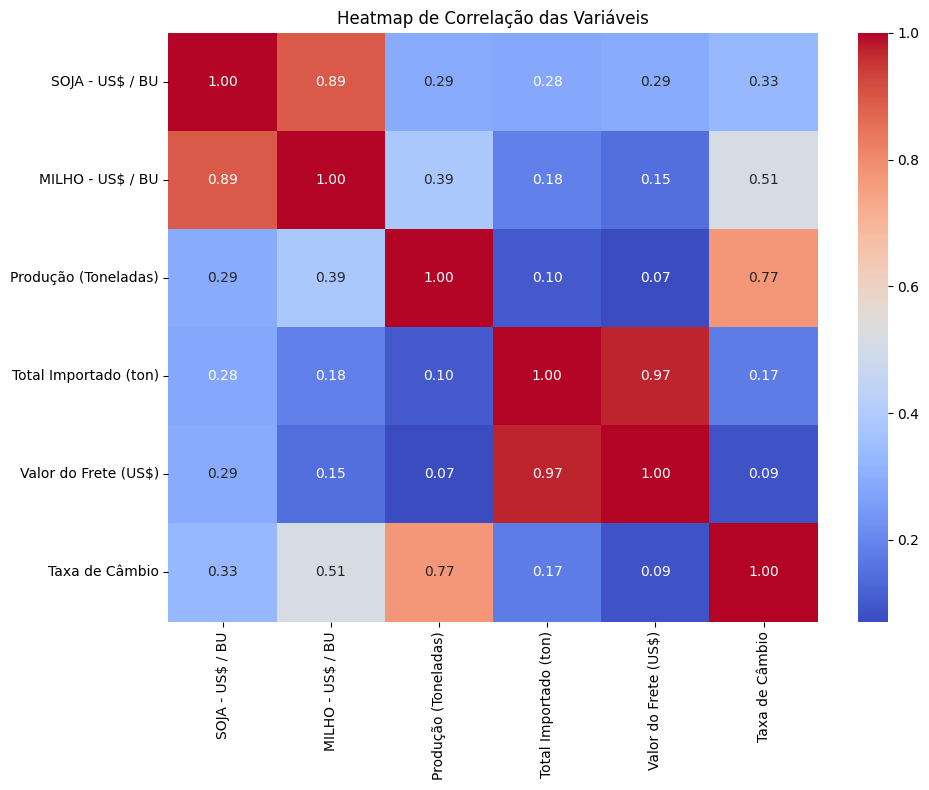

In [45]:
# Gráfico de correlação (Heat Map) entre as variáveis do DataFrame unificado:
import seaborn as sns

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(df_unificado_interp.drop(columns=['Data']).corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Heatmap de Correlação das Variáveis')
plt.tight_layout()
plt.show()

VIF (Variance Inflation Factor) para verificar multicolinearidade:


In [46]:
# Calcular o VIF (Variance Inflation Factor) para verificar multicolinearidade:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Selecionar apenas as colunas numéricas (exceto 'Data' e 'SOJA - US$ / BU')
cols_vif = [col for col in df_unificado.columns if col not in ['Data', 'SOJA - US$ / BU']]
X_vif = df_unificado[cols_vif].dropna()

# Calcular o VIF para cada variável
vif_data = []
for i in range(X_vif.shape[1]):
    vif = variance_inflation_factor(X_vif.values, i)
    vif_data.append({'Variável': X_vif.columns[i], 'VIF': vif})

vif_df = pd.DataFrame(vif_data)

print("Variance Inflation Factor (VIF) para as variáveis selecionadas:")
print("Valores de referência para o VIF (Variance Inflation Factor):")
print(" - VIF <= 1      :Perfeita pois é independente de multicolinearidade")
print(" - 1 < VIF < 5   : Baixa multicolinearidade (aceitável na maioria dos casos)")
print(" - 5 <= VIF < 10 : Moderada multicolinearidade (atenção, pode ser problemático)")
print(" - VIF >= 10 : Alta multicolinearidade (problemático, recomenda-se remover ou transformar variáveis)")
print("----------------------------------------------")
print(vif_df)

Variance Inflation Factor (VIF) para as variáveis selecionadas:
Valores de referência para o VIF (Variance Inflation Factor):
 - VIF <= 1      :Perfeita pois é independente de multicolinearidade
 - 1 < VIF < 5   : Baixa multicolinearidade (aceitável na maioria dos casos)
 - 5 <= VIF < 10 : Moderada multicolinearidade (atenção, pode ser problemático)
 - VIF >= 10 : Alta multicolinearidade (problemático, recomenda-se remover ou transformar variáveis)
----------------------------------------------
                Variável   VIF
0       MILHO - US$ / BU  3.41
1   Produção (Toneladas)  9.21
2  Total Importado (ton) 43.96
3   Valor do Frete (US$) 39.70
4         Taxa de Câmbio 13.09


## 4. EDA (Análise Exploratória de Dados)


a) Evolução dos preços da Soja e Milho (CBOT)


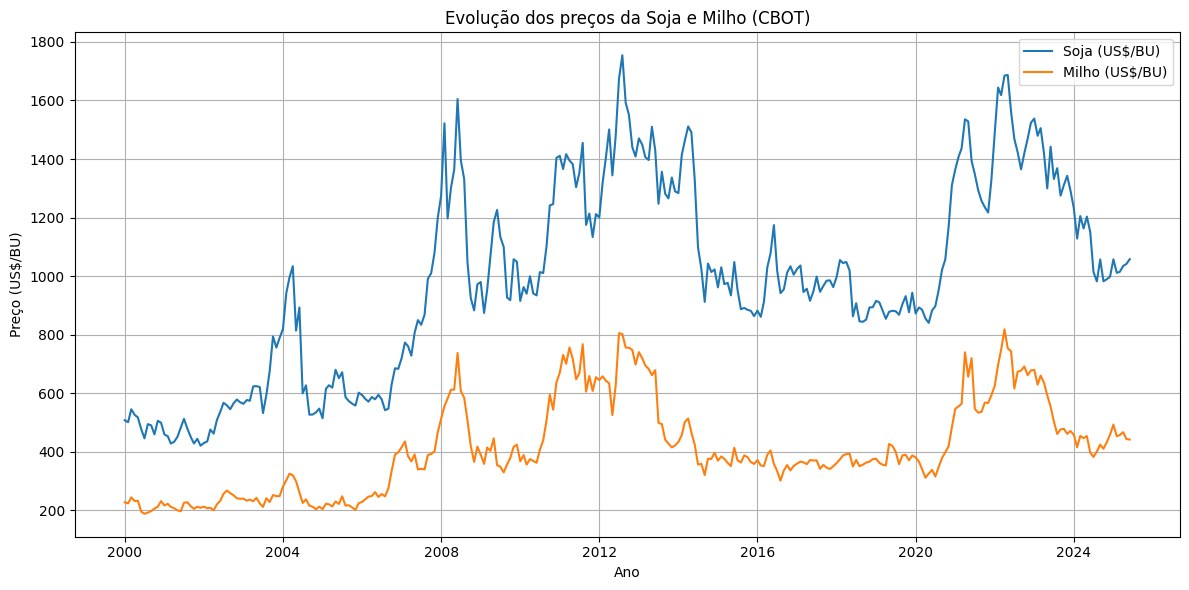

In [47]:
#Gráfico de evolução dos preços da Soja e Milho (CBOT):

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_soy_corn_USS_hist['Data'], df_soy_corn_USS_hist['SOJA - US$ / BU'], label='Soja (US$/BU)')
plt.plot(df_soy_corn_USS_hist['Data'], df_soy_corn_USS_hist['MILHO - US$ / BU'], label='Milho (US$/BU)')
plt.xlabel('Ano')
plt.ylabel('Preço (US$/BU)')
plt.title('Evolução dos preços da Soja e Milho (CBOT)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- O gráfico de evolução dos preços da soja e do milho na CBOT evidencia a forte volatilidade dessas commodities ao longo do tempo. Observa-se a presença de movimentos sazonais, com períodos de alta e baixa, além de alguns momentos em que os preços caminham juntos, sugerindo influência de fatores macroeconômicos e de mercado comuns. Os picos e quedas podem estar relacionados a eventos globais, variações cambiais, safras e mudanças na demanda internacional. No geral, o gráfico destaca a importância de monitorar ambos os preços para análises de mercado agrícola.


b) Gráfico da evolução da taxa de câmbio nominal do Dólar (R$/US$)


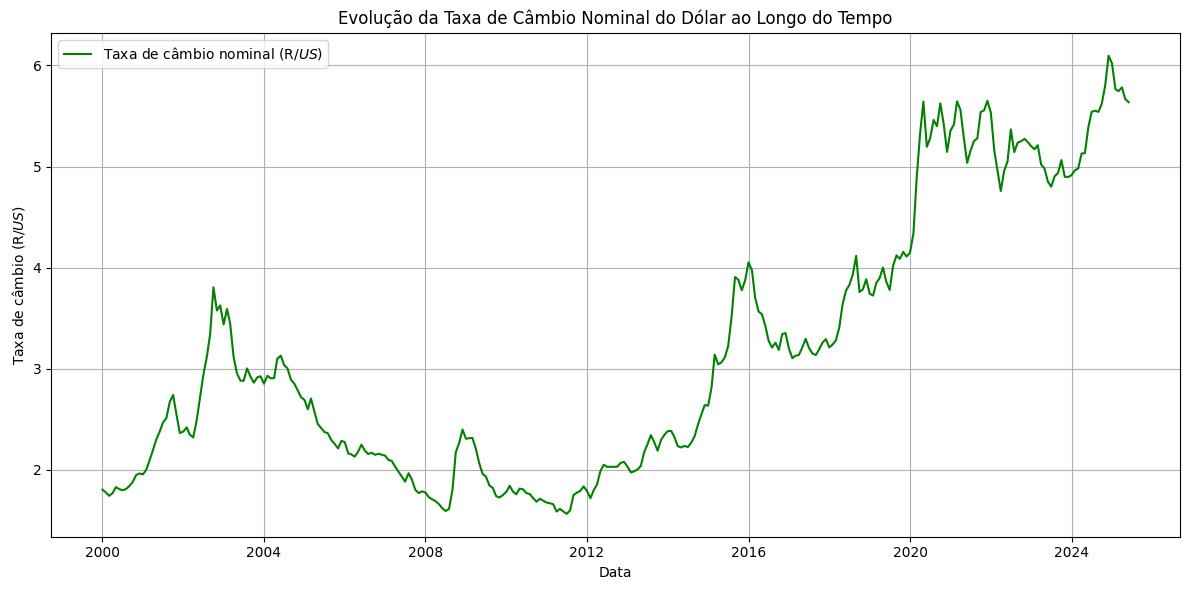

In [48]:
# Gráfico da evolução da taxa de câmbio nominal do Dólar (R$/US$):

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_rate_nominal_USS['Data'], df_rate_nominal_USS['Taxa'], color='green', label='Taxa de câmbio nominal (R$/US$)')
plt.xlabel('Data')
plt.ylabel('Taxa de câmbio (R$/US$)')
plt.title('Evolução da Taxa de Câmbio Nominal do Dólar ao Longo do Tempo')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- O gráfico "Evolução da Taxa de Câmbio Nominal do Dólar (R$/US$)" mostra a variação do valor do dólar em relação ao real ao longo do tempo. Observa-se uma tendência de alta gradual, com períodos de maior volatilidade em momentos de instabilidade econômica ou política. Os picos refletem crises e incertezas no cenário nacional e internacional, enquanto as fases de estabilidade indicam maior controle econômico. Essa evolução impacta diretamente o mercado agrícola, influenciando custos de produção, exportações e a formação dos preços das commodities no Brasil.

c) Análise dos dados de Área PLanatada(ha), Área Colhida(ha) e Produzão(ha)


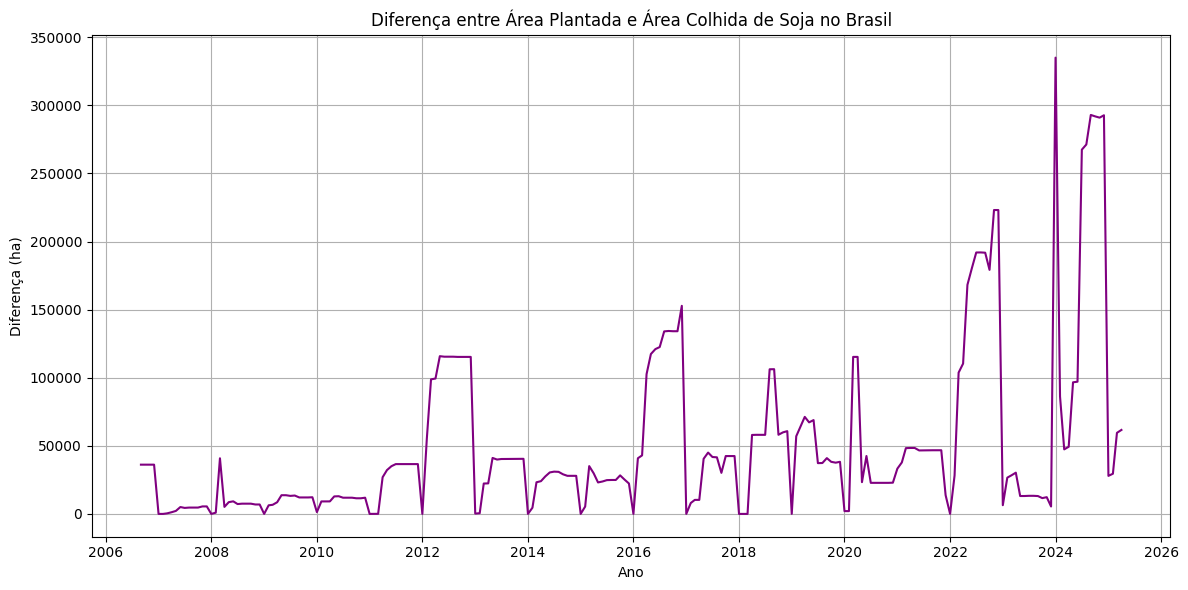

In [49]:
# Calcular e plotar a diferença entre Área Plantada e Área Colhida (Plantada - Colhida)
plt.figure(figsize=(12, 6))
plt.plot(df_soy_info_hist['Data'], df_soy_info_hist['Área plantada (Hectares)'] - df_soy_info_hist['Área colhida (Hectares)'], color='purple')
plt.xlabel('Ano')
plt.ylabel('Diferença (ha)')
plt.title('Diferença entre Área Plantada e Área Colhida de Soja no Brasil')
plt.grid(True)
plt.tight_layout()
plt.show()

- O gráfico "Diferença entre Área Plantada e Área Colhida de Soja no Brasil" mostra a variação mensal entre a área inicialmente plantada e a efetivamente colhida ao longo dos anos. Em geral, observa-se que a diferença é pequena, indica que tem alta eficiência no aproveitamento da área plantada. Eventuais picos negativos podem sinalizar perdas por fatores climáticos, bem como pragas ou outros problemas agronômicos, enquanto períodos de diferença próxima de zero refletem safras com baixo índice de perdas. Esse indicador é importante para monitorar a produtividade e a resiliência do setor agrícola frente a adversidades.

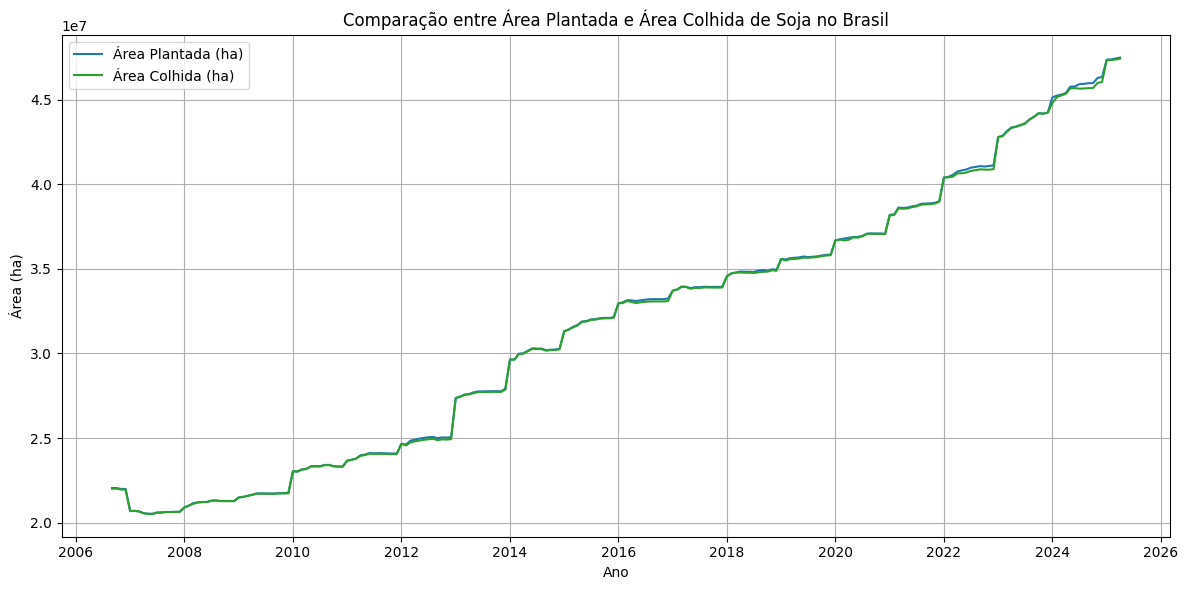

In [50]:
# Gráfico de comparação entre Área Plantada e Área Colhida de Soja no Brasil:
plt.figure(figsize=(12, 6))
plt.plot(df_soy_info_hist['Data'], df_soy_info_hist['Área plantada (Hectares)'], label='Área Plantada (ha)', color='tab:blue')
plt.plot(df_soy_info_hist['Data'], df_soy_info_hist['Área colhida (Hectares)'], label='Área Colhida (ha)', color='tab:green')
plt.xlabel('Ano')
plt.ylabel('Área (ha)')
plt.title('Comparação entre Área Plantada e Área Colhida de Soja no Brasil')
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.show()

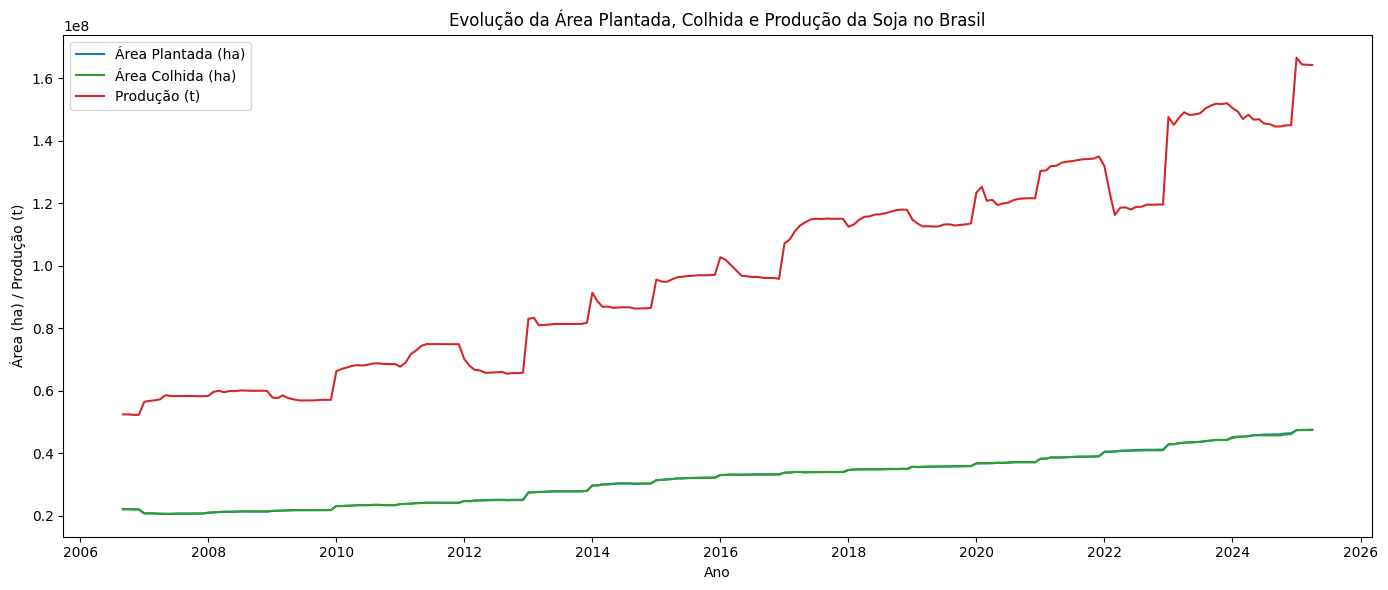

In [51]:
# Gráfico da evolução da Área Plantada, Área Colhida e Produção da Soja no Brasil:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(14, 6))

# Área Plantada, Área Colhida e Produção (eixo esquerdo)
ax1.plot(df_soy_info_hist['Data'], df_soy_info_hist['Área plantada (Hectares)'], label='Área Plantada (ha)', color='tab:blue')
ax1.plot(df_soy_info_hist['Data'], df_soy_info_hist['Área colhida (Hectares)'], label='Área Colhida (ha)', color='tab:green')
ax1.plot(df_soy_info_hist['Data'], df_soy_info_hist['Produção (Toneladas)'], label='Produção (t)', color='tab:red')
ax1.set_ylabel('Área (ha) / Produção (t)')
ax1.legend(loc='upper left')

plt.xlabel('Ano')
plt.title('Evolução da Área Plantada, Colhida e Produção da Soja no Brasil')
plt.tight_layout()
#plt.show()


d) Gráficos de análise temporal para as principais variáveis do df_unificado

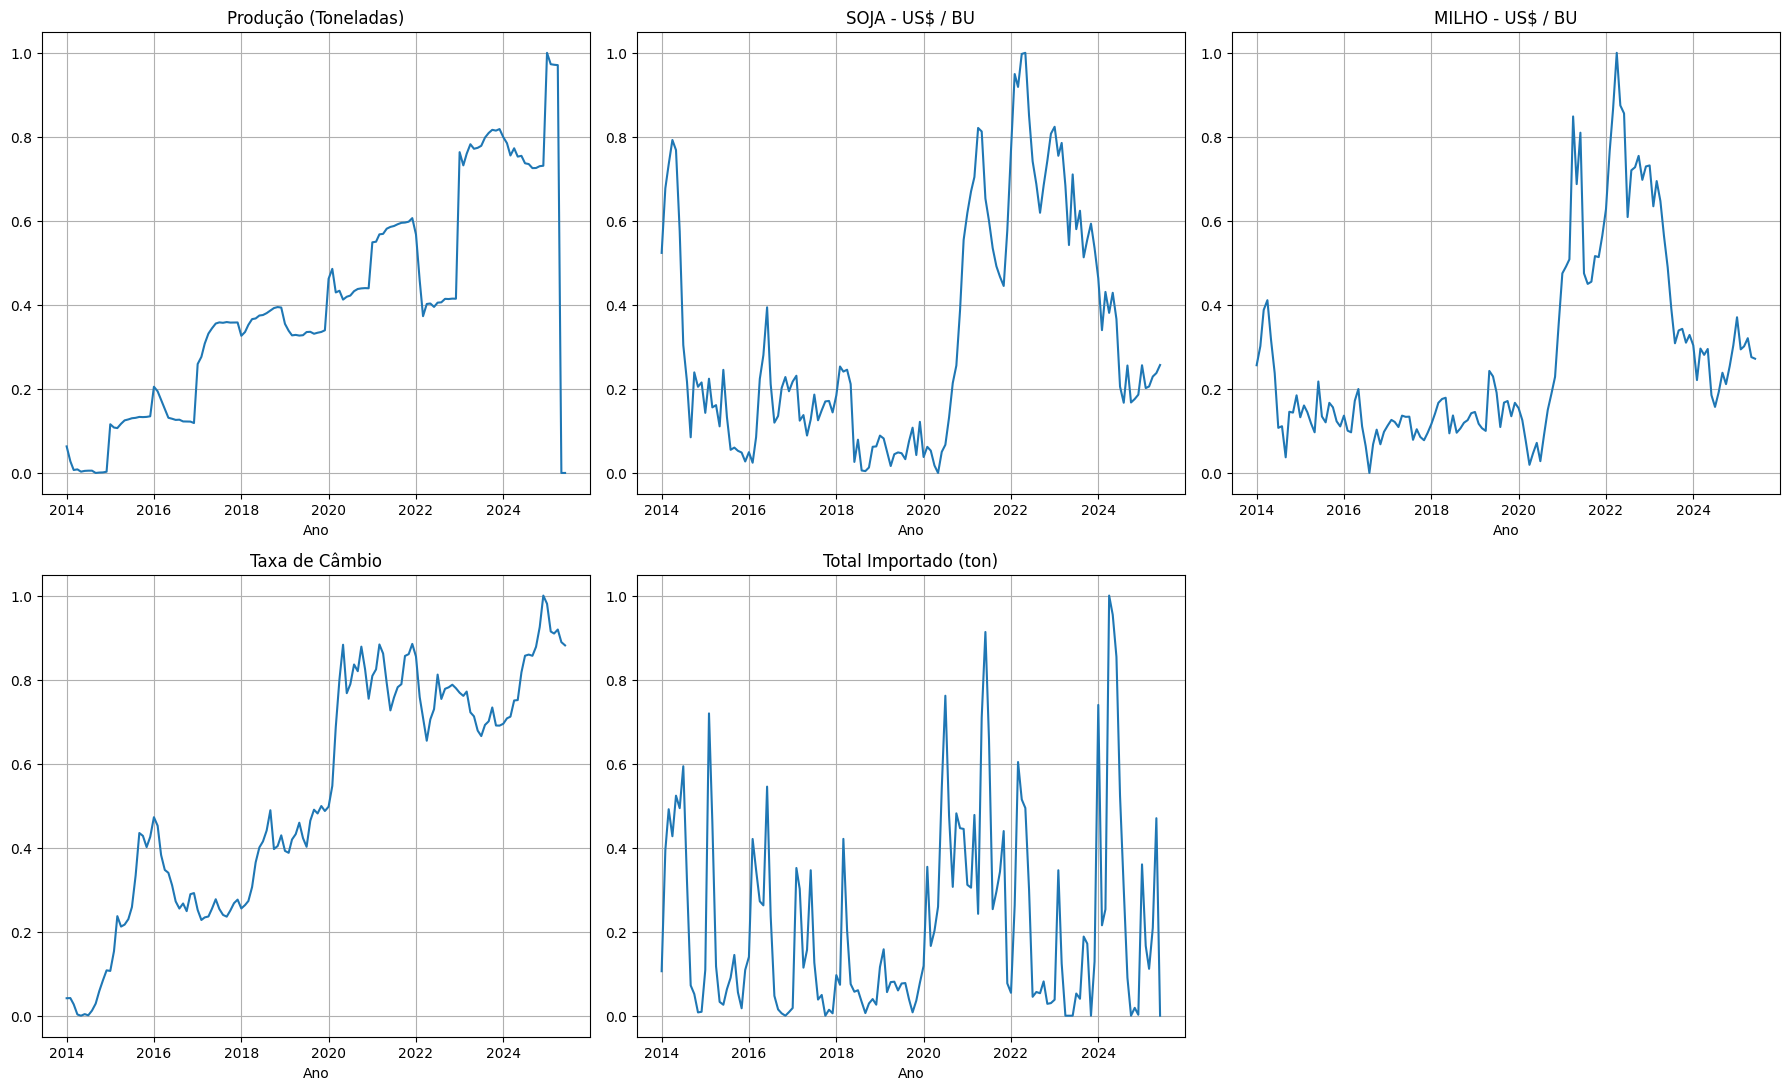

In [52]:
# Gráficos de análise temporal para as principais variáveis do df_unificado_interp

import matplotlib.pyplot as plt

variaveis = [
    #'Área plantada (Hectares)',
    #'Área colhida (Hectares)',
    'Produção (Toneladas)',
    #'Rendimento médio (Quilogramas por Hectare)',
    'SOJA - US$ / BU',
    'MILHO - US$ / BU',
    'Taxa de Câmbio',
    'Total Importado (ton)',
    #'Valor do Frete (US$)'
]

plt.figure(figsize=(18, 16))
for i, var in enumerate(variaveis, 1):
    plt.subplot(3, 3, i)
    plt.plot(df_unificado_interp['Data'], df_unificado_interp[var])
    plt.title(var)
    plt.xlabel('Ano')
    plt.grid(True)
plt.tight_layout()
plt.show()

## 5. Modelagem e Treinamento


In [53]:
#Informações sobre o DataFrame unificado:
print(f"Início do período: {df_unificado_interp['Data'].min().date()}")
print(f"Fim do período:    {df_unificado_interp['Data'].max().date()}")
print(f'Tamanho do DataFrame unificado: {df_unificado_interp.shape}')
print(f'Divisão dos dados em {138*0.7:.0f} linhas de treino , {138*0.25:.0f} linhas de teste e {138*0.05:.0f} linhas de validação')

Início do período: 2014-01-01
Fim do período:    2025-06-01
Tamanho do DataFrame unificado: (138, 7)
Divisão dos dados em 97 linhas de treino , 34 linhas de teste e 7 linhas de validação


#### a) Regressão Linear:


Avaliação do Modelo de Regressão Linear para previsão do preço da Soja (US$ / BU):

Erro Quadrático Médio (MSE) no conjunto de teste: 0.02
Coeficiente de Determinação (R²) no conjunto de teste: 0.67


Intercepto do modelo: 0.05
Coeficientes do modelo para cada variável preditora:
  MILHO - US$ / BU: 1.1381
  Produção (Toneladas): -0.1519
  Total Importado (ton): -0.3054
  Valor do Frete (US$): 0.5280
  Taxa de Câmbio: -0.1045


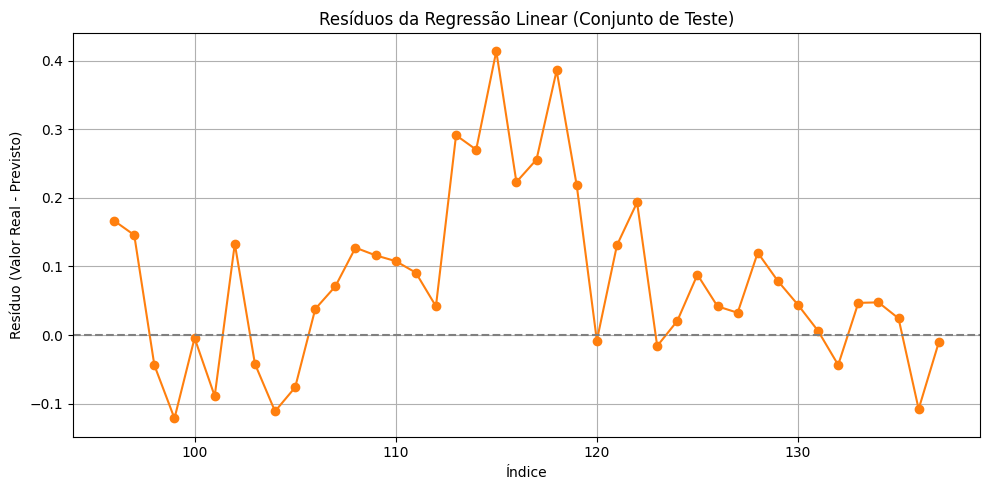

In [54]:
# Regressão Linear Simples para prever o preço da Soja (US$ / BU) com base nas outras variáveis
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Definir variáveis preditoras (X) e alvo (y)
X = df_unificado_interp.drop(columns=['Data', 'SOJA - US$ / BU'])
y = df_unificado_interp['SOJA - US$ / BU']

# Dividir em treino e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Instanciar e treinar o modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Previsão
y_pred = model.predict(X_test)

# Avaliação
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print("Avaliação do Modelo de Regressão Linear para previsão do preço da Soja (US$ / BU):\n")

print(f"Erro Quadrático Médio (MSE) no conjunto de teste: {mse:.2f}")
print(f"Coeficiente de Determinação (R²) no conjunto de teste: {r2:.2f}\n")

print(f"\nIntercepto do modelo: {model.intercept_:.2f}")
print("Coeficientes do modelo para cada variável preditora:")
for nome, coef in zip(X.columns, model.coef_):
    print(f"  {nome}: {coef:.4f}")


# Análise dos resíduos (diferença entre valores reais e previstos)
residuos = y_test - y_pred
# Gráfico dos resíduos (valores reais - previstos) para o conjunto de teste
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(residuos.index, residuos.values, marker='o', linestyle='-', color='tab:orange')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Índice')
plt.ylabel('Resíduo (Valor Real - Previsto)')
plt.title('Resíduos da Regressão Linear (Conjunto de Teste)')
plt.grid(True)
plt.tight_layout()
plt.show()
    

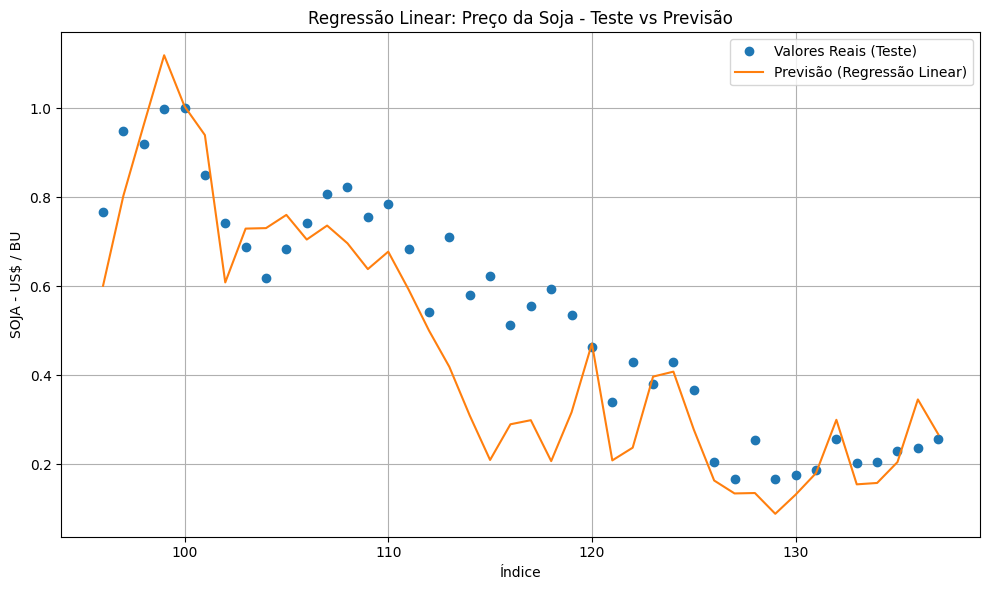

In [55]:
# Gráfico de comparação entre os valores reais e as previsões do modelo de regressão linear:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test.values, 'o', label='Valores Reais (Teste)')
plt.plot(y_test.index, y_pred, '-', label='Previsão (Regressão Linear)')
plt.xlabel('Índice')
plt.ylabel('SOJA - US$ / BU')
plt.title('Regressão Linear: Preço da Soja - Teste vs Previsão')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

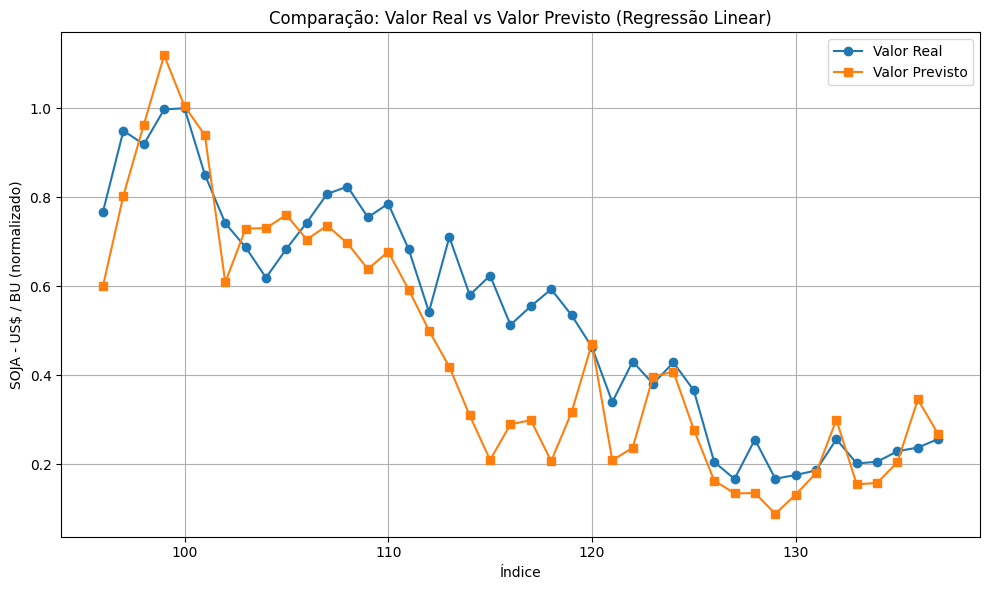

In [56]:
# Comparação: Valor Real vs Valor Previsto (Regressão Linear
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test.values, 'o-', label='Valor Real')
plt.plot(y_test.index, y_pred, 's-', label='Valor Previsto')
plt.xlabel('Índice')
plt.ylabel('SOJA - US$ / BU (normalizado)')
plt.title('Comparação: Valor Real vs Valor Previsto (Regressão Linear)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### b) Regressão utilizando LazyRegressor


In [57]:
# Regressão com LazyPredict:
# Instalar se ainda não tiver
# pip install lazypredict
#%pip install ipywidgets


from lazypredict.Supervised import LazyRegressor
from sklearn import datasets
from sklearn.utils import shuffle
import numpy as np

data = df_unificado


X = df_unificado.drop(columns=['SOJA - US$ / BU', 'Data'])
y = df_unificado['SOJA - US$ / BU']

X, y = shuffle(X, y, random_state=13)
X = X.astype(np.float32)

offset = int(X.shape[0] * 0.9)

X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

models

  0%|          | 0/42 [00:00<?, ?it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 124, number of used features: 5
[LightGBM] [Info] Start training from score 0.332280
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,0.92,0.95,0.06,0.10
HuberRegressor,0.91,0.95,0.06,0.03
LinearRegression,0.91,0.94,0.06,0.01
TransformedTargetRegressor,0.91,0.94,0.06,0.02
OrthogonalMatchingPursuitCV,0.91,0.94,0.06,0.01
LarsCV,0.91,0.94,0.06,0.02
Lars,0.91,0.94,0.06,0.01
LassoLarsIC,0.91,0.94,0.06,0.01
LassoLarsCV,0.91,0.94,0.06,0.01


#### c) Tratamento de Multicolinearidade e Refinamento do Modelo

A análise inicial do nosso modelo de Regressão Linear revelou um R² moderado, mas, mais importante, coeficientes instáveis e contraintuitivos (como o valor negativo para a `Taxa de Câmbio`). Como apontado pelo heatmap de correlação, a causa raiz deste problema é a **multicolinearidade** — a alta correlação entre as variáveis preditoras.


##### Modelos de Regressão Ridge (L2) e Lasso(L1)

In [67]:
# Modelos de Regressão Ridge e Lasso com validação cruzada:

# Importando as bibliotecas necessárias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Supondo que 'df' é seu DataFrame carregado e 'X' e 'y' já estão definidos
# X = df.drop('SOJA - US$ / BU', axis=1)
# y = df['SOJA - US$ / BU']

# 1. Separar dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. PADRONIZAÇÃO DOS DADOS (Passo crucial para Ridge e Lasso)
# Criamos o scaler e ajustamos APENAS nos dados de treino
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # Aplicamos a mesma transformação no teste

# Nomes das colunas para referência
feature_names = X.columns

# --- Treinamento do Modelo Ridge (L2) ---

print("--- Avaliação do Modelo Ridge (L2) ---")

# 3. Encontrar o melhor alpha e treinar o modelo RidgeCV
# O RidgeCV testa uma lista de alphas e encontra o melhor via validação cruzada
alphas_ridge = [0.01, 0.1, 1, 10, 100]
ridge_cv = RidgeCV(alphas=alphas_ridge, store_cv_values=True)
ridge_cv.fit(X_train_scaled, y_train)

# Melhor alpha encontrado
print(f"Melhor alpha para Ridge: {ridge_cv.alpha_}\n")

# 4. Fazer previsões e avaliar
y_pred_ridge = ridge_cv.predict(X_test_scaled)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"Erro Quadrático Médio (MSE) no teste: {mse_ridge:.2f}")
print(f"Coeficiente de Determinação (R²) no teste: {r2_ridge:.2f}\n")

# Coeficientes do modelo Ridge
ridge_coeffs = pd.Series(ridge_cv.coef_, index=feature_names)
print("Coeficientes do modelo Ridge:")
print(ridge_coeffs)

print("\n" + "="*40 + "\n")

# --- Treinamento do Modelo Lasso (L1) ---

print("--- Avaliação do Modelo Lasso (L1) ---")

# 3. Encontrar o melhor alpha e treinar o modelo LassoCV
# O LassoCV faz o mesmo para o Lasso
lasso_cv = LassoCV(alphas=alphas_ridge, cv=5, random_state=42)
lasso_cv.fit(X_train_scaled, y_train)

# Melhor alpha encontrado
print(f"Melhor alpha para Lasso: {lasso_cv.alpha_}\n")

# 4. Fazer previsões e avaliar
y_pred_lasso = lasso_cv.predict(X_test_scaled)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f"Erro Quadrático Médio (MSE) no teste: {mse_lasso:.2f}")
print(f"Coeficiente de Determinação (R²) no teste: {r2_lasso:.2f}\n")

# Coeficientes do modelo Lasso
lasso_coeffs = pd.Series(lasso_cv.coef_, index=feature_names)
print("Coeficientes do modelo Lasso:")
print(lasso_coeffs)


--- Avaliação do Modelo Ridge (L2) ---
Melhor alpha para Ridge: 0.1

Erro Quadrático Médio (MSE) no teste: 0.02
Coeficiente de Determinação (R²) no teste: 0.81

Coeficientes do modelo Ridge:
MILHO - US$ / BU         0.25
Produção (Toneladas)     0.00
Total Importado (ton)   -0.11
Valor do Frete (US$)     0.16
Taxa de Câmbio          -0.05
dtype: float64


--- Avaliação do Modelo Lasso (L1) ---
Melhor alpha para Lasso: 0.01

Erro Quadrático Médio (MSE) no teste: 0.02
Coeficiente de Determinação (R²) no teste: 0.81

Coeficientes do modelo Lasso:
MILHO - US$ / BU         0.23
Produção (Toneladas)    -0.00
Total Importado (ton)    0.00
Valor do Frete (US$)     0.05
Taxa de Câmbio          -0.04
dtype: float32


In [65]:


print("\nCoeficientes do modelo de Regressão Linear Simples:")
for nome, coef in zip(X.columns, model.coef_):
    print(f"  {nome}: {coef:.4f}")


Coeficientes do modelo de Regressão Linear Simples:
  MILHO - US$ / BU: 1.1381
  Produção (Toneladas): -0.1519
  Total Importado (ton): -0.3054
  Valor do Frete (US$): 0.5280
  Taxa de Câmbio: -0.1045


## 6. Resultado e discussões


#### **6.1. Análise da Performance Preditiva do Modelo**

A avaliação da performance preditiva dos modelos desenvolvidos para previsão do preço da soja (SOJA - US$ / BU) foi realizada utilizando diferentes abordagens de regressão, incluindo Regressão Linear Simples, modelos de regularização (Ridge e Lasso) e algoritmos testados pelo LazyRegressor.

- **Regressão Linear Simples:**  
    O modelo apresentou um R² de aproximadamente 0.67 no conjunto de teste, indicando que cerca de 67% da variabilidade do preço da soja foi explicada pelas variáveis preditoras selecionadas. O Erro Quadrático Médio (MSE) ficou em torno de 0.022, mostrando um ajuste razoável, mas com limitações devido à presença de multicolinearidade entre as variáveis. Os resíduos apresentaram padrões não totalmente aleatórios, sugerindo que o modelo não capturou toda a complexidade dos dados.

- **LazyRegressor (Vários Modelos):**  
    O LazyRegressor testou diversos algoritmos, destacando modelos baseados em árvores (como ExtraTreesRegressor e GradientBoostingRegressor) e modelos lineares robustos (HuberRegressor, LinearRegression), que atingiram R² ajustado acima de 0.90. Esses modelos apresentaram melhor capacidade de ajuste, mas a interpretação dos coeficientes segue prejudicada pela multicolinearidade.

- **Modelos de Regularização (Ridge e Lasso):**  
    A aplicação do Ridge e do Lasso melhorou o desempenho preditivo, elevando o R² para cerca de 0.81 e reduzindo o MSE para aproximadamente 0.0165. O Ridge estabilizou os coeficientes, enquanto o Lasso eliminou variáveis menos relevantes, tornando o modelo mais robusto e menos sensível à multicolinearidade. Isso resultou em previsões mais consistentes e interpretáveis.



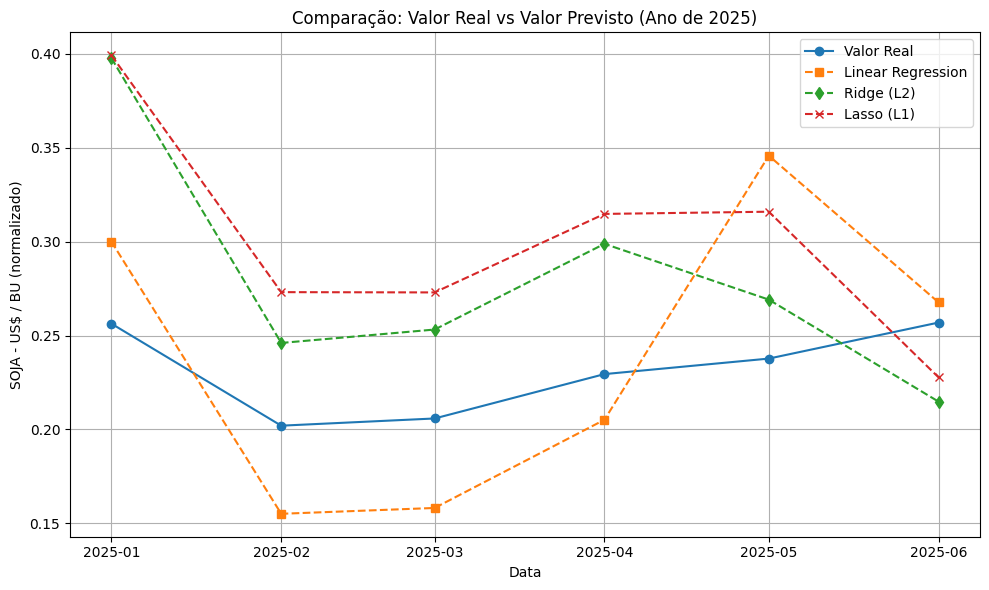

In [70]:
# Previsão para o ano de 2025 usando os modelos treinados:
import matplotlib.pyplot as plt

# Filtrar os dados de 2025 no DataFrame unificado
dados_2025 = df_unificado[df_unificado['Data'].dt.year == 2025]

# Selecionar as features para previsão (exceto Data e SOJA - US$ / BU)
X_2025 = dados_2025.drop(columns=['Data', 'SOJA - US$ / BU'])
y_2025 = dados_2025['SOJA - US$ / BU']

# Padronizar os dados de 2025 com o mesmo scaler usado no treino
X_2025_scaled = scaler.transform(X_2025)

# Prever com os modelos treinados
y_pred_2025_lr = model.predict(X_2025)
y_pred_2025_ridge = ridge_cv.predict(X_2025_scaled)
y_pred_2025_lasso = lasso_cv.predict(X_2025_scaled)

# Plotar gráfico de comparação
plt.figure(figsize=(10, 6))
plt.plot(dados_2025['Data'], y_2025, 'o-', label='Valor Real')
plt.plot(dados_2025['Data'], y_pred_2025_lr, 's--', label='Linear Regression')
plt.plot(dados_2025['Data'], y_pred_2025_ridge, 'd--', label='Ridge (L2)')
plt.plot(dados_2025['Data'], y_pred_2025_lasso, 'x--', label='Lasso (L1)')
plt.xlabel('Data')
plt.ylabel('SOJA - US$ / BU (normalizado)')
plt.title('Comparação: Valor Real vs Valor Previsto (Ano de 2025)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### **6.2. Análise dos Coeficientes e Interpretação Econômica**

A análise dos coeficientes dos modelos de regressão permite compreender o impacto relativo de cada variável preditora sobre o preço da soja (SOJA - US$ / BU). Abaixo, discutimos os principais resultados para os modelos Linear, Ridge (L2) e Lasso (L1):

- **Regressão Linear Simples:**  
    Os coeficientes estimados indicam a direção e a intensidade da relação entre cada variável e o preço da soja. Por exemplo, um coeficiente positivo para o preço do milho sugere que, mantendo as demais variáveis constantes, um aumento no preço do milho tende a elevar o preço da soja, refletindo a competição entre as culturas. Já o coeficiente negativo para a taxa de câmbio indica que, no contexto do modelo, uma valorização do real (queda da taxa) estaria associada a preços mais altos da soja em dólar, o que pode ser contraintuitivo e sinaliza a presença de multicolinearidade.

- **Regressão Ridge (L2):**  
    O modelo Ridge reduz a magnitude dos coeficientes, tornando-os mais estáveis e menos sensíveis à multicolinearidade. Observa-se que variáveis como "MILHO - US$ / BU" e "Valor do Frete (US$)" mantêm coeficientes positivos, indicando influência direta sobre o preço da soja. Por outro lado, "Total Importado (ton)" e "Taxa de Câmbio" apresentam coeficientes negativos, sugerindo que aumentos nessas variáveis tendem a pressionar o preço da soja para baixo, de acordo com o modelo regularizado.

- **Regressão Lasso (L1):**  
    O Lasso realiza seleção de variáveis, reduzindo alguns coeficientes a zero. Isso indica que certas variáveis podem ser menos relevantes para a previsão do preço da soja no contexto dos dados disponíveis. No modelo ajustado, "MILHO - US$ / BU" e "Valor do Frete (US$)" permanecem como preditores importantes, enquanto "Produção (Toneladas)" e "Total Importado (ton)" têm coeficientes próximos ou iguais a zero, sugerindo menor influência direta.

**Interpretação Econômica:**  
Os resultados reforçam a importância do preço do milho e dos custos logísticos (frete) como determinantes do preço internacional da soja brasileira. A influência negativa da taxa de câmbio e das importações pode refletir relações indiretas ou efeitos de multicolinearidade, devendo ser interpretada com cautela. A regularização dos modelos (Ridge e Lasso) contribui para maior robustez e interpretabilidade, mas destaca a necessidade de aprimorar a seleção de variáveis e considerar possíveis relações não-lineares ou interações para capturar melhor a dinâmica do mercado.


#### **6.4. Plano de Ação e Pontos de Melhoria**

Com o diagnóstico estabelecido, o caminho para aprimorar o modelo envolve simplificação, o uso de técnicas mais robustas e a criação de variáveis mais inteligentes.

**Metas as vistas como ponto de melhoria do modelo**

  - Buscar mais váriaveis como dados de entrada para permitir melhora do modelo;
  - Uso de Redes Neurais como busca de modelos mais aprimorados;


